In [126]:
library(forecast, lib.loc="./local_R_pack") # pacchetto forecast
library(plyr)

ERROR: Error: package ‘leaps’ required by ‘TSA’ could not be found


In [10]:
df = read.csv('./Data/Storico/clean_dataset.csv') 

ita <- df[df$country_code == 'IT',]
ita <- ita[!(ita$provincia == 'Undefined'),]

prov = unique(ita$provincia)

est <- df[!(df$country_code == 'IT'),]
stato <- unique(est$country_code)

out_ita <- vector("list", length(prov))
out_est <- vector("list", length(stato))

alldates <- data.frame(dep_day=seq(as.Date('2017-01-01'), (as.Date('2017-03-30')), by="day"))

In [78]:
create_row_days <- function(tab){
    ret = integer(7)
    ifelse(is.na(tab['Sunday']), 0, tab['Sunday'])
    ret[1] = ifelse(is.na(tab['Monday']), 0, tab['Monday'])
    ret[2] = ifelse(is.na(tab['Tuesday']), 0, tab['Tuesday'])
    ret[3] = ifelse(is.na(tab['Wednesday']), 0, tab['Wednesday'])
    ret[4] = ifelse(is.na(tab['Thursday']), 0, tab['Thursday'])
    ret[5] = ifelse(is.na(tab['Friday']), 0, tab['Friday'])
    ret[6] = ifelse(is.na(tab['Saturday']), 0, tab['Saturday'])
    ret[7] = ifelse(is.na(tab['Sunday']), 0, tab['Sunday'])
    
    return (ret)
}

In [79]:
# create dataset to store "days occurences" per province
n_prov = length(prov)
days_occ_ita <- data.frame(provincia = character(n_prov),
                           Monday = integer(n_prov),
                           Tuesday = integer(n_prov),
                           Wednesday = integer(n_prov),
                           Thursday = integer(n_prov),
                           Friday = integer(n_prov),
                           Saturday = integer(n_prov),
                           Sunday = integer(n_prov),
                          stringsAsFactors=FALSE)

In [170]:
# predizione di due settimane, Italia
for(i in 1:n_prov){
    sub = ita[ita$provincia == prov[i], c('dep_day','seatsleft','fullseats','seats')]

    sub['tot'] = sub['seats'] + sub['fullseats']
    sub$dep_day = as.Date(sub$dep_day)
    sub = sub[sub$dep_day < '2017-03-31',]
    sub <- aggregate(sub$tot, by=list(dep_day=sub$dep_day), FUN=sum) # group by same data
    
    sub$weekday <- weekdays(sub$dep_day)
    days_occ_ita[i,1] <- as.character(prov[i])
    days_occ_ita[i,2:8] <- create_row_days(table(sub$weekday))

    # merge
    sub <- merge(sub, alldates, by="dep_day", all=TRUE) # fill missing dates with 0
    sub[is.na(sub)] <- 0

    # prediction
    y <- ts(sub$x, frequency = 7)
    arima.fore.seas <- forecast(auto.arima(y, D = 1, allowdrift = FALSE), h=14)   
    out_ita[[i]] <- arima.fore.seas
}

In [81]:
# create dataset to store "days occurences" per country
n_countries = length(stato)
days_occ_est <- data.frame(country = character(n_countries),
                           Monday = integer(n_countries),
                           Tuesday = integer(n_countries),
                           Wednesday = integer(n_countries),
                           Thursday = integer(n_countries),
                           Friday = integer(n_countries),
                           Saturday = integer(n_countries),
                           Sunday = integer(n_countries),
                          stringsAsFactors=FALSE)

In [171]:
# predizione di due settimane, Estero
for(i in 1:n_countries){
    sub = est[est$country_code == stato[i], c('dep_day','seatsleft','fullseats','seats')]

    sub['tot'] = sub['seats'] + sub['fullseats']
    sub$dep_day = as.Date(sub$dep_day)
    sub = sub[sub$dep_day < '2017-03-31',]
    sub <- aggregate(sub$tot, by=list(dep_day=sub$dep_day), FUN=sum) # group by same data
    
    sub$weekday <- weekdays(sub$dep_day)
    days_occ_est[i,1] <- as.character(stato[i])
    days_occ_est[i,2:8] <- create_row_days(table(sub$weekday))

    # merge
    sub <- merge(sub, alldates, by="dep_day", all=TRUE) # fill missing dates with 0
    sub[is.na(sub)] <- 0

    # prediction
    y <- ts(sub$x, frequency = 7)
    arima.fore.seas <- forecast(auto.arima(y, D = 1, allowdrift = FALSE), h=14)   
    out_est[[i]] <- arima.fore.seas
}

In [186]:
prova = out_ita[1]

In [202]:
out_ita[1][[1]]$mean

Time Series:
Start = c(13, 6) 
End = c(15, 5) 
Frequency = 7 
 [1] 37.456695  6.419253 11.689117  6.930159  4.132412  5.273043  9.986451
 [8] 37.332862  6.419253 11.689117  6.930159  4.132412  5.273043  9.986451

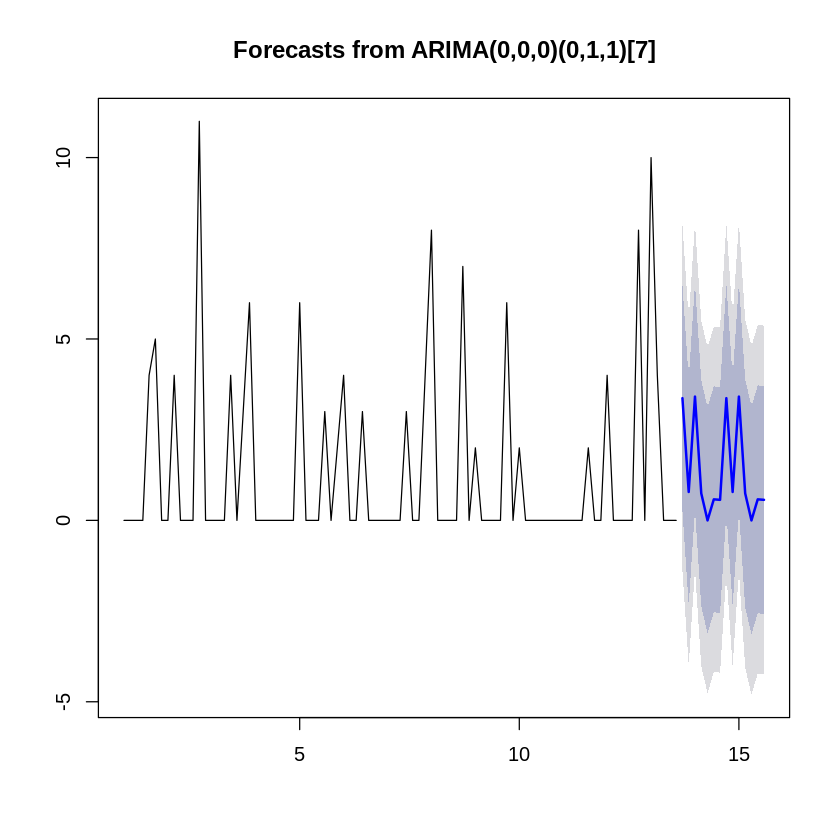

In [224]:
for (i in 1:n_prov){
    if (prov[i] == 'Gorizia'){
       plot(out_ita[[i]]) 
    }
}

In [205]:
# prepare dataset for storing the results
ita_pred <- data.frame(prov = character(n_prov),
                        Fri_1= double(n_prov),
                        Sat_1 = double(n_prov),
                        Sun_1 = double(n_prov),
                        Mon_1 = double(n_prov),
                        Tue_1 = double(n_prov),
                        Wed_1 = double(n_prov),
                        Thu_1 = double(n_prov),
                        Fri_2 = double(n_prov),
                        Sat_2 = double(n_prov),
                        Sun_2 = double(n_prov),
                        Mon_2 = double(n_prov),
                        Tue_2 = double(n_prov),
                        Wed_2 = double(n_prov),
                        Thu_2 = double(n_prov),
                          stringsAsFactors=FALSE)

est_pred <- data.frame(country = character(n_countries),
                        Fri_1= double(n_countries),
                        Sat_1 = double(n_countries),
                        Sun_1 = double(n_countries),
                        Mon_1 = double(n_countries),
                        Tue_1 = double(n_countries),
                        Wed_1 = double(n_countries),
                        Thu_1 = double(n_countries),
                        Fri_2 = double(n_countries),
                        Sat_2 = double(n_countries),
                        Sun_2 = double(n_countries),
                        Mon_2 = double(n_countries),
                        Tue_2 = double(n_countries),
                        Wed_2 = double(n_countries),
                        Thu_2 = double(n_countries),
                          stringsAsFactors=FALSE)

In [206]:
# fill the the datasets
for (i in 1:n_prov){
    ita_pred[i,1] <- as.character(prov[i])
    ita_pred[i,2:15] <- out_ita[i][[1]]$mean
}

for (i in 1:n_countries){
    est_pred[i,1] <- as.character(stato[i])
    est_pred[i,2:15] <- out_est[i][[1]]$mean
}

In [214]:
days_occ

provincia,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Ancona,10,8,12,11,12,12,9
Aosta,8,11,10,12,12,12,12
Monza-Brianza,10,10,10,10,5,9,7
Ascoli Piceno,8,7,5,5,10,5,5
Lecco,11,9,9,11,11,8,9
Bergamo,13,13,13,13,12,12,13
Bologna,13,13,13,13,12,12,13
Brescia,13,13,13,12,12,12,13
Novara,9,13,9,7,12,10,12
Caserta,2,1,1,2,7,2,2


In [215]:
# write outputs to csv
write.csv(ita_pred, './Data/ita_pred.csv')
write.csv(est_pred, './Data/est_pred.csv')
write.csv(days_occ, './Data/ita_days.csv')
write.csv(days_occ_est, './Data/est_days.csv')